In [2]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas

np.random.seed(10)
print (tf.__version__)

2.7.0


In [3]:
# Reading the dataset
data = pandas.read_csv('colors.csv')
data.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


In [5]:
names = data["name"]

## Visualize the name string length distribution

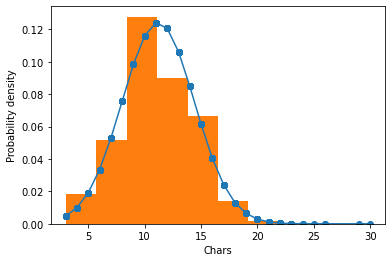

In [8]:

h = sorted(names.str.len().to_numpy())
import numpy as np
import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit,'-o')
plt.hist(h,density=True)      #use this to draw histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

In [9]:
np.array(h).max()

30

## Tokenize, char level

In [10]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

In [56]:
# Saving trainned tokens

import pickle


# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

## One-hot encoding

In [11]:
from keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)
num_classes = one_hot_names.shape[-1]
num_classes

28

In [12]:
one_hot_names.shape

(14157, 25, 28)

In [14]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])


In [17]:
# Create model

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25, 256)           291840    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 505,859
Trainable params: 505,859
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=40,
                    batch_size=32,
                    validation_split=0.1)

2022-04-23 07:14:26.869995: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40
399/399 [==============================] - 41s 100ms/step - loss: 0.0601 - acc: 0.6226 - val_loss: 0.0598 - val_acc: 0.6518
Epoch 2/40
399/399 [==============================] - 42s 105ms/step - loss: 0.0551 - acc: 0.6667 - val_loss: 0.0558 - val_acc: 0.6674
Epoch 3/40
399/399 [==============================] - 44s 109ms/step - loss: 0.0524 - acc: 0.6646 - val_loss: 0.0536 - val_acc: 0.6617
Epoch 4/40
399/399 [==============================] - 45s 112ms/step - loss: 0.0499 - acc: 0.6639 - val_loss: 0.0518 - val_acc: 0.6702
Epoch 5/40
399/399 [==============================] - 46s 115ms/step - loss: 0.0479 - acc: 0.6646 - val_loss: 0.0523 - val_acc: 0.6850
Epoch 6/40
399/399 [==============================] - 46s 116ms/step - loss: 0.0457 - acc: 0.6754 - val_loss: 0.0492 - val_acc: 0.6688
Epoch 7/40
399/399 [==============================] - 48s 120ms/step - loss: 0.0436 - acc: 0.6744 - val_loss: 0.0473 - val_acc: 0.6928
Epoch 8/40
399/399 [==============================] - 4

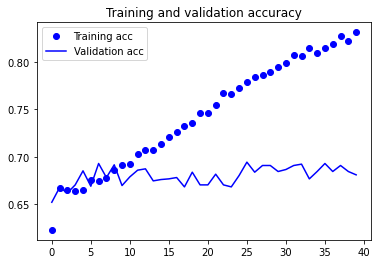

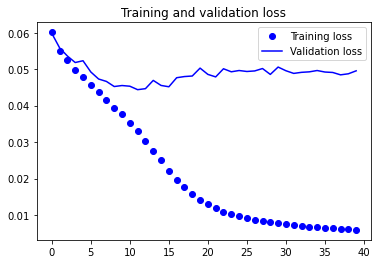

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [23]:
# Plot a color image.
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [24]:
def scale(n):
    return int(n * 255) 

In [47]:
def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=num_classes)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)
    return (r,g,b)

light blue, R,G,B: 157 212 236


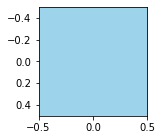

blue, R,G,B: 21 45 190


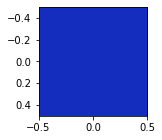

dark blue, R,G,B: 8 18 100


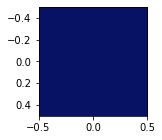

In [26]:
predict("light blue")
predict("blue")
predict("dark blue")

black, R,G,B: 20 17 26


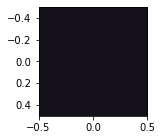

white, R,G,B: 242 238 227


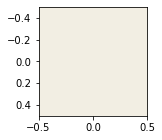

In [27]:
predict("black")
predict("white")

keras red, R,G,B: 214 22 79


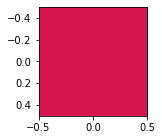

In [31]:
predict("keras red")

In [49]:
## Convert rgb to HEX
'#%02x%02x%02x' % (r, g, b)


'#168d99'

In [53]:
# Save the entire model as a SavedModel.

model.save('tr_model')

INFO:tensorflow:Assets written to: tr_model/assets
